<a href="https://colab.research.google.com/github/NickKar30/GM-HSE-AI-masters-course/blob/main/Hometasks/Base/GenDL_HT1_base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание - 1 (базовая группа)

В этом домашнем задании вы потренируетесь решать задачу speech-to-text.

Вы не будете тренировать сложную архитектуру с нуля, а попробуете решить эту задачу, пройдя по пайплайну, в котором задача разбита на несколько простых шагов.

- В этом задании мы призываем вас по-максимуму использовать документацию моделей и получить опыт написания кода без заготовок

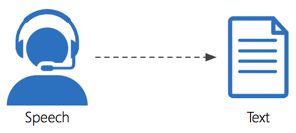

In [ ]:
# %pip install -q transformers datasets torchaudio evaluate


## Шаг 1 (1 балл)

* Возьмите датасет https://disk.yandex.ru/d/v2Hipv7XG4fEDQ, содержащий русскоязычные аудиозаписи

* Примените модель [whisper-small](https://huggingface.co/openai/whisper-small) из HF для определения сказанного в аудио.

* Выведите результат работы модели для 10 случайных аудио из датасета

Не стесняйтесь пользоваться документацией и источниками знаний из интернета!

In [1]:
import os
import random
import torch
import torchaudio
from pathlib import Path
import csv

from transformers import WhisperProcessor, WhisperForConditionalGeneration


### Загрузим список URL с файлами датасета

In [2]:
# предварительно сохранить файл https://disk.yandex.ru/d/v2Hipv7XG4fEDQ как `urls_normalized.tsv`

DATA_ROOT = Path("data_russian_speech")
DATA_ROOT.mkdir(parents=True, exist_ok=True)
TSV_PATH = Path("./urls_normalized.tsv")

urls = []

with TSV_PATH.open("r", encoding="utf-8") as f:
    tsv_reader = csv.reader(f, delimiter="\t")
    for row in tsv_reader:
        urls.append(row[0].strip())

print(f"Найдено {len(urls)} URL для скачивания.")


Найдено 100 URL для скачивания.


### Скачаем аудио-файлы

In [3]:
import requests
from tqdm.auto import tqdm

def download_file(url: str, dest_path: Path):
    """Загрузка одного файла (с прогресс-баром)."""
    filename = url.split("/")[-1] + ".wav"
    target_file = dest_path / filename

    if target_file.is_file():
        print(f"✔️  Уже существует: {filename}")
        return

    # Потоковое скачивание, чтобы не грузить много в память
    with requests.get(url, stream=True, timeout=30) as r:
        r.raise_for_status()
        total = int(r.headers.get("content-length", 0))
        with tqdm(total=total, unit="B", unit_scale=True, desc=filename) as pbar:
            with open(target_file, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    if chunk:  # могут быть пустые - keep-alive
                        f.write(chunk)
                        pbar.update(len(chunk))

    print(f"✅  Загружен: {filename}")

for url in urls:
    try:
        download_file(url, DATA_ROOT)
    except Exception as e:
        print(f"❌  Ошибка загрузки {url}: {e}")


✔️  Уже существует: 197f271b-b23f-4ee0-b240-e956a172d7af.wav
✔️  Уже существует: 3d8c8d43-f7f2-479b-a857-c90faa5e2faf.wav
✔️  Уже существует: 45161c4c-3f2c-4638-940e-a69404074ebb.wav
✔️  Уже существует: 3c0ebd62-2cc1-4c9c-be63-5733511a11cd.wav
✔️  Уже существует: 6385560c-7068-45c2-9ba7-9e061249e0a4.wav
✔️  Уже существует: c4f3178c-14b2-44f8-b36e-f34a47520e10.wav
✔️  Уже существует: 0f2ef6c9-3dec-45ae-b456-8115c9419044.wav
✔️  Уже существует: 4711cdac-8181-4f3c-8889-77cf408f3ff2.wav
✔️  Уже существует: 37e917e1-1fdf-4064-a74f-57a84bcb28b9.wav
✔️  Уже существует: d203c652-509b-4c41-bdaf-f374e1c3c87e.wav
✔️  Уже существует: c53908cc-adb1-418b-b68b-f67094fc4afd.wav
✔️  Уже существует: a6bab1dc-059b-4f93-a2ec-baef363ddcea.wav
✔️  Уже существует: dc7eedda-8db3-4ea5-abcd-d8ecb9fec734.wav
✔️  Уже существует: 29c0f7f4-9701-4e19-a4cd-874ec5397be1.wav
✔️  Уже существует: fcceeeb4-5bb7-460a-853c-99c3c7bd5aef.wav
✔️  Уже существует: 969c8460-29a8-4c6a-ac71-bc729a6d1f3d.wav
✔️  Уже существует: 22d8

### Вспомогательные функции загрузки аудио-файлов

In [5]:
import wave
import numpy as np
import torch

def load_wav_file(filepath):
    """Считывание WAV-файла и получение тензора PyTorch"""
    with wave.open(filepath, 'rb') as wav_file:
        # Параметры аудиофайла
        channels = wav_file.getnchannels()
        sample_width = wav_file.getsampwidth()
        framerate = wav_file.getframerate()
        frames = wav_file.getnframes()
        
        # Считаем аудиоданные
        raw_audio = wav_file.readframes(frames)
        
        # Конвертируем в numpy array
        if sample_width == 1:
            dtype = np.uint8
        elif sample_width == 2:
            dtype = np.int16
        elif sample_width == 4:
            dtype = np.int32
        else:
            raise ValueError(f'Неподдерживаемый "sample width": {sample_width}')
            
        audio_data = np.frombuffer(raw_audio, dtype=dtype)
        
        # Reshape, если многоканальное аудио
        if channels > 1:
            audio_data = audio_data.reshape(-1, channels)
            
        # Нормализация к диапазону [-1, 1]
        if dtype == np.uint8:
            audio_data = (audio_data.astype(np.float32) - 128) / 128
        else:
            audio_data = audio_data.astype(np.float32) / np.iinfo(dtype).max
            
        # Получить тензор PyTorch
        tensor = torch.from_numpy(audio_data)
        
        # Приведение к структуре (channels, samples) для PyTorch
        if len(tensor.shape) == 1:
            tensor = tensor.unsqueeze(0)  # добавить измерение
        else:
            tensor = tensor.transpose(0, 1)  # переставить измерения (samples, channels) -> (channels, samples)
            
        return tensor, framerate

# тестовый 
device = "mps" if torch.backends.mps.is_available() else "cpu"
audio_tensor, sample_rate = load_wav_file("./data_russian_speech/00760e69-35b8-4c65-84f6-c1d0e82907c2.wav")
audio_tensor = audio_tensor.to(device)

print(f"Загружено: {audio_tensor.shape} @ {sample_rate}Hz")


Загружено: torch.Size([1, 36160]) @ 16000Hz


In [7]:
import torchaudio
def load_audio(path: str, target_sr: int = 16000):
    wav, sr = load_wav_file(path)
    # Многоканальное усредним до "моно"
    if wav.shape[0] > 1:
        wav = wav.mean(dim=0, keepdim=True)
    # пересэмплируйте имеющиеся аудио в 16 kHz - пример кода ниже, можете его менять
    if sr != target_sr:
        wav = torchaudio.functional.resample(wav, orig_freq=sr, new_freq=target_sr)
        sr = target_sr
    return wav.squeeze(0), sr


### Подготовка модели Whisper

In [6]:
model_name = "openai/whisper-small"

# загрузка пре-процессора (токенизатор и конвертер в mel-спектрограммы)
processor = WhisperProcessor.from_pretrained(model_name)
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# загрузка самой модели 
model = WhisperForConditionalGeneration.from_pretrained(model_name).to(device)
# перевод в режим инференса
model.eval()

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

WhisperForConditionalGeneration(
  (model): WhisperModel(
    (encoder): WhisperEncoder(
      (conv1): Conv1d(80, 768, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv2): Conv1d(768, 768, kernel_size=(3,), stride=(2,), padding=(1,))
      (embed_positions): Embedding(1500, 768)
      (layers): ModuleList(
        (0-11): 12 x WhisperEncoderLayer(
          (self_attn): WhisperAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (self_attn_layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (activation_fn): GELUActivation()
          (fc1): Linear(in_features=768, out_features=3072, bias=True)
          (fc2): Linear(in_features=3072, out_features=768, bias=True)
          (f

### Запуск распознавания аудио

In [ ]:
audio_dir = Path("data_russian_speech")
wav_paths = list(audio_dir.rglob("*.wav"))

print(f"Найдено {len(wav_paths)} аудиофайлов для обработки")

for i, p in enumerate(wav_paths):
    print(f"Обрабатывается файл {i+1}/{len(wav_paths)}: {p.name}")
    
    wav, sr = load_audio(str(p))

    inputs = processor(wav, sampling_rate=sr, return_tensors="pt")
    input_features = inputs.input_features.to(model.device)
    
    # Создаем attention_mask если его нет
    if hasattr(inputs, 'attention_mask') and inputs.attention_mask is not None:
        attention_mask = inputs.attention_mask.to(model.device)
    else:
        # Создаем маску внимания для всех элементов (все единицы)
        attention_mask = torch.ones(input_features.shape[:2], dtype=torch.long, device=model.device)

    # Генерация выходных токенов
    predicted_ids = model.generate(
        input_features, 
        attention_mask=attention_mask,
        language="ru", 
        task="transcribe"
    )

    # Декодирование в текст
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)[0]
    
    # Сохраняем транскрипцию в файл
    txt_filename = p.stem + ".txt"  # p.stem дает имя файла без пути и без расширения
    txt_path = audio_dir / txt_filename
    
    with open(txt_path, 'w', encoding='utf-8') as f:
        f.write(transcription)
    
    print(f"Транскрипция сохранена в: {txt_filename}")

print("Все файлы обработаны!")



Найдено 100 аудиофайлов для обработки
Обрабатывается файл 1/100: 3d8c8d43-f7f2-479b-a857-c90faa5e2faf.wav
Транскрипция сохранена в: 3d8c8d43-f7f2-479b-a857-c90faa5e2faf.txt
Обрабатывается файл 2/100: 53085fa6-1df6-4d46-ae00-4ce2b89ac0ca.wav
Транскрипция сохранена в: 53085fa6-1df6-4d46-ae00-4ce2b89ac0ca.txt
Обрабатывается файл 3/100: 0a450eae-9d55-4bf0-aba8-a6f2e1162706.wav
Транскрипция сохранена в: 0a450eae-9d55-4bf0-aba8-a6f2e1162706.txt
Обрабатывается файл 4/100: 1f418f48-7d16-41c4-b1ec-a06ec58aacfd.wav
Транскрипция сохранена в: 1f418f48-7d16-41c4-b1ec-a06ec58aacfd.txt
Обрабатывается файл 5/100: d203c652-509b-4c41-bdaf-f374e1c3c87e.wav
Транскрипция сохранена в: d203c652-509b-4c41-bdaf-f374e1c3c87e.txt
Обрабатывается файл 6/100: c5a115d7-015f-421c-94ce-ed9928151491.wav
Транскрипция сохранена в: c5a115d7-015f-421c-94ce-ed9928151491.txt
Обрабатывается файл 7/100: 3c0ebd62-2cc1-4c9c-be63-5733511a11cd.wav
Транскрипция сохранена в: 3c0ebd62-2cc1-4c9c-be63-5733511a11cd.txt
Обрабатывается фа

### Отображение 10 рандомных транскрипций

In [34]:
import random

txt_files = list(audio_dir.rglob("*.txt"))
sample_txt_files = random.sample(txt_files, k=min(10, len(txt_files)))

print("10 случайных транскрипций:")
print("=" * 50)

for txt_file in sample_txt_files:
    with open(txt_file, 'r', encoding='utf-8') as f:
        transcription = f.read().strip()
    
    print(f"Файл: {txt_file.name}")
    print(f"Транскрипция: {transcription}")
    print("-" * 40)


10 случайных транскрипций:
Файл: 47b9b402-e832-438d-ad85-3f7375867e4a.txt
Транскрипция: КОУ ПОРТЕР
----------------------------------------
Файл: 4bd0ad25-e86a-4275-85b6-4d11ac96cfdc.txt
Транскрипция: Мой отец и мой сын
----------------------------------------
Файл: 969c8460-29a8-4c6a-ac71-bc729a6d1f3d.txt
Транскрипция: Криминальная чтива.
----------------------------------------
Файл: d69a744d-0510-4a61-9705-95901544390f.txt
Транскрипция: Мммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммммм
----------------------------------------
Файл: f9d9fa24-0e3c-430f-8e42-622a0fa0c6a5.txt
Транскрипция: Кейт Буш.

## Шаг 2 (1 балл)

Текст распознается с ошибками.
Попробуйте исправить ошибки с помощью готовой (предобученной) модели spell correction.

Выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели https://huggingface.co/UrukHan/t5-russian-spell.

In [ ]:
# ваш код здесь

## Шаг 3 (2 балла)

Соберите данные для дообучения модели выше. Для дообучения мы предлагаем вам использовать бесплатный api Groq: https://console.groq.com/docs/quickstart

Разберитесь с тем как пользоваться api (мы немного поможем вам с этим кодом ниже) и с его помощью соберите датасет (можно в несколько запросов).

- **0.5 балла** ставится за сбор датасета размером >1000 строк и сохранение в локальный файл/файлы

- **еще 0.5 балла** ставится за [создание huggingface dataset](https://huggingface.co/docs/datasets/create_dataset) (через использование библиотек datasets и huggingface) и [сохранение собранного датасета напрямую в HuggingFace](https://huggingface.co/docs/datasets/upload_dataset)

- **еще 1 балл** ставится за сбор датасета размером >1000 строк, на котором путем дообучения получится увеличить качество исправления опечаток в поставленной задаче (см. шаг 6) по сравнению с качеством прогноза той же, но предобученной модели

P.S. Если у Вас нет VPN, то можете воспользоваться другой LLM на Ваш выбор (можно, например, этим https://ollama.com/).

In [ ]:
# зайдите на страницу и создайте API KEY: https://console.groq.com/keys - возможно, понадобится включить VPN

import os

os.environ["GROQ_API_KEY"] = <YOUR API KEY>

In [ ]:
!pip install groq

In [ ]:
import os
from groq import Groq

client = Groq(api_key=os.environ.get("GROQ_API_KEY"))

response = client.chat.completions.create(
    messages=[{"role": "user", "content": <YOUR PROMPT>}],
#    model="llama-3.3-70b-versatile",
    model="DeepSeek-R1-Distill-Llama-70B",
)

print(response.choices[0].message.content)

In [ ]:
# Ваш код для подключения к Groq и промпты

In [ ]:
# Сохраните собранный датасет в файл и прикрепите сюда ссылку на него

## Шаг 4 (2 балла)

Дообучите модель выше или любую другую модель, которая вам нравится, на собранных данных и протестируйте ее на нескольких ошибочно распознанных whisper-small моделью аудио. Дообучение мы разбирали на семинаре - можете посмотреть, как мы это делали там.

Для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

- Вы можете воспользовать структурой, предложенной в ячейке ниже, а можете написать код по-своему.

In [ ]:
!pip install --upgrade transformers datasets

In [ ]:
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainer, Seq2SeqTrainingArguments

# Модель
...

# Загружаем свой CSV с парами (input → target)
...

# Токенизация
...

# Data collator
...

# Аргументы обучения
training_args = Seq2SeqTrainingArguments(...)

# Trainer
trainer = Seq2SeqTrainer(...)

# Запускаем обучение
trainer.train()

# Сохраняем дообученную модель
trainer.save_model("...")
tokenizer.save_pretrained("...")

Примените дообученную модель. Как раз здесь для оценки качества результата выведите на экран 10 текстов с предыдущего шага и их исправления с помощью модели.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Загружаем дообученную модель
model_path = "..."
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSeq2SeqLM.from_pretrained(model_path)

# Применение модели к 10 примерам
...

## Шаг 5 (1 балл)

Время считать метрики и возвращаться к дообучению модели по необходимости. В этом шаге мы оцениваем только выполнение задания, а не значения метрик.

a) [Здесь](https://disk.yandex.ru/d/SPJU3lCt_cMDcw) лежат правильные ответы почти на все аудио - считайте метрики только для аудио, для которых мы дали вам ответы. Посчитайте [WER](https://docs.pytorch.org/torcheval/main/generated/torcheval.metrics.WordErrorRate.html) для модели whisper-small.

б) Посчитайте WER для whisper-small + исправление опечаток предобученной моделью (модель выберите самостоятельно!)

в) Посчитайте WER для whisper-small + дообученная Вами модель (данные для дообучения и модель выберите самостоятельно!)

In [ ]:
# ваш код здесь

## Шаг 6 (3 балла)

В этом шаге предлагаем вам провести максимум рисерча и экспериментов для наиболее качественного решения задачи (в бесплатном google colab, без привлечения дополнительных мощностей)

* Поищите предобученные модели, применение которых для задачи speech-to-text дает меньше опечаток (меньше WER)

* Протестируйте несколько spell-correction моделей и сделайте выводы какая из них лучше (с точки зрения WER)

* Возьмите лучшую из найденных моделей и попытайтесь улучшить ее через шаг 4, как делали ранее. Попробуйте немного изменить обучение в шаге 4, чтобы добиться еще более хороших результатов (изменить данные/гиперпараметры и т.п.) и проведите соответствующий эксперимент. Объясните почему ваша модификация шага 4 теоретически может улучшить результаты и сделайте выводы о том, получилось ли улучшить качество (если нет, то предположите почему).

In [ ]:
# ваши эксперименты здесь